In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu Sep 19 07:38:02 2019

@author: mor
"""


import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report , confusion_matrix , precision_recall_curve
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score , roc_auc_score , average_precision_score, homogeneity_score, silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sn
import pickle
from sklearn.cluster import DBSCAN



In [2]:


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [3]:


filenames = glob.glob('data\\chapter_3\\*.csv')
filenames = sorted(filenames)
df = pd.read_csv(filenames[0])



In [4]:


# Get the dataframe shape
print(df.shape)

# Display the first 5 rows
print(df.head())

# Groupby categories and take the mean
print(df.groupby('category').mean())



(7200, 5)
  age gender           category  amount  fraud
0   3      F  es_transportation   49.71      0
1   4      F          es_health   39.29      0
2   3      F  es_transportation   18.76      0
3   4      M  es_transportation   13.95      0
4   2      M  es_transportation   49.87      0
                           amount     fraud
category                                   
es_barsandrestaurants   43.841793  0.022472
es_contents             55.170000  0.000000
es_fashion              59.780769  0.020619
es_food                 35.216050  0.000000
es_health              126.604704  0.242798
es_home                120.688317  0.208333
es_hotelservices       172.756245  0.548387
es_hyper                46.788180  0.125000
es_leisure             229.757600  1.000000
es_otherservices       149.648960  0.600000
es_sportsandtoys       157.251737  0.657895
es_tech                132.852862  0.179487
es_transportation       27.422014  0.000000
es_travel              231.818656  0.944444
es_w

In [5]:


# Group by age groups and get the mean
print(df.groupby('age').mean())

# Count the values of the observations in each age group
print(df['age'].value_counts())



        amount     fraud
age                     
0    49.468935  0.050000
1    35.622829  0.026648
2    37.228665  0.028718
3    37.279338  0.023283
4    36.197985  0.035966
5    37.547521  0.023990
6    36.700852  0.022293
U    39.117000  0.000000
2    2333
3    1718
4    1279
5     792
1     713
6     314
0      40
U      11
Name: age, dtype: int64


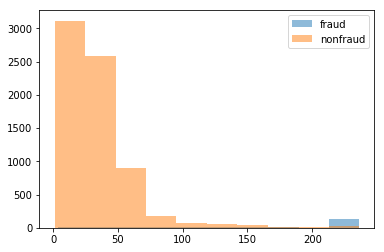

In [6]:


# Create two dataframes with fraud and non-fraud data 
df_fraud = df.loc[df.fraud == 1] 
df_non_fraud = df.loc[df.fraud == 0]

# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud.amount, alpha=0.5, label='fraud')
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud')
plt.legend()
plt.show()



In [7]:


df = pd.read_csv(filenames[1])
y = df.fraud
df.drop('fraud',axis=1,inplace=True)


In [8]:


# Import the scaler
from sklearn.preprocessing import MinMaxScaler

# Take the float values of df for X
X = df.values.astype(np.float)

# Define the scaler and apply to the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)



In [9]:


# Import MiniBatchKmeans 
from sklearn.cluster import MiniBatchKMeans

# Define the model 
kmeans = MiniBatchKMeans(n_clusters=8, random_state=0)

# Fit the model to the scaled data
kmeans.fit(X_scaled)



MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=8,
        n_init=3, random_state=0, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

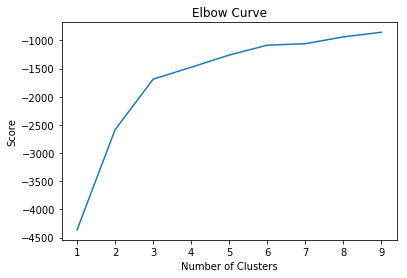

In [10]:


# Define the range of clusters to try
clustno = range(1, 10)

# Run MiniBatch Kmeans over the number of clusters
kmeans = [MiniBatchKMeans(n_clusters=i) for i in clustno]

# Obtain the score for each model
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

# Plot the models and their respective score 
plt.plot(clustno, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()



In [11]:


# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)

# Define K-means model 
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42).fit(X_train)

# Obtain predictions and calculate distance from cluster centroid
X_test_clusters = kmeans.predict(X_test)
X_test_clusters_centers = kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x, y in zip(X_test, X_test_clusters_centers[X_test_clusters])]

# Create fraud predictions based on outliers on clusters 
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 95)] = 1
km_y_pred[dist < np.percentile(dist, 95)] = 0



In [12]:


def plot_confusion_matrix(km_cm):
  df_cm = pd.DataFrame(km_cm, ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
  plt.figure(figsize = (8,4))
  sn.set(font_scale=1.4) 
  sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')
#  plt.ylim(-0.5,1.5)
  plt.show()



0.8109115999408585


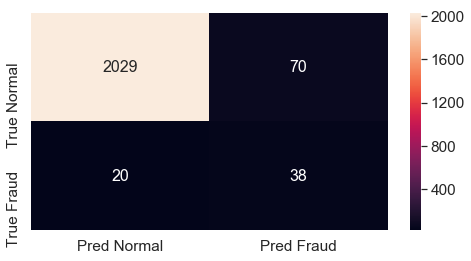

In [13]:

# Obtain the ROC score
print(roc_auc_score(y_test, km_y_pred))

# Create a confusion matrix
km_cm = confusion_matrix(y_test, km_y_pred)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(km_cm)



In [14]:

import pickle
with open( 'data/chapter_3/x_scaled.pickle', 'rb') as f:
    X_scaled= pickle.load(f)
with open( 'data/chapter_3/labels.pickle', 'rb') as f:
    labels= pickle.load(f)



In [15]:


# Import DBSCAN
from sklearn.cluster import DBSCAN

# Initialize and fit the DBscan model
db = DBSCAN(eps=0.9, min_samples=10, n_jobs=-1).fit(X_scaled)

# Obtain the predicted labels and calculate number of clusters
pred_labels = db.labels_
n_clusters = len(set(pred_labels)) - (1 if -1 in labels else 0)

# Print performance metrics for DBscan
print('Estimated number of clusters: %d' % n_clusters)
print("Homogeneity: %0.3f" % homogeneity_score(labels, pred_labels))
print("Silhouette Coefficient: %0.3f" % silhouette_score(X_scaled, pred_labels))



Estimated number of clusters: 18
Homogeneity: 0.633
Silhouette Coefficient: 0.707


In [16]:

import pickle
with open( 'data/chapter_3/x_scaled_full.pickle', 'rb') as f:
    X_scaled= pickle.load(f)
with open( 'data/chapter_3/labels_full.pickle', 'rb') as f:
    labels= pickle.load(f)

db = DBSCAN(eps=0.9, min_samples=10, n_jobs=-1).fit(X_scaled)

# Obtain the predicted labels and calculate number of clusters
pred_labels = db.labels_
n_clusters = len(set(pred_labels)) - (1 if -1 in labels else 0)



In [17]:

# Count observations in each cluster number
counts = np.bincount(pred_labels[pred_labels>=0])

# Sort the sample counts of the clusters and take the top 3 smallest clusters
smallest_clusters = np.argsort(counts)[:3]

# Print the counts of the smallest clusters only
print("Their counts are:")      
print(counts[smallest_clusters])



Their counts are:
[10 15 15]


In [18]:


# Create a dataframe of the predicted cluster numbers and fraud labels 
df = pd.DataFrame({'clusternr':pred_labels,'fraud':labels})

# Create a condition flagging fraud for the smallest clusters 
df['predicted_fraud'] = np.where((df['clusternr']==21)|(df['clusternr']==17)|(df['clusternr']==9),1 , 0)

# Run a crosstab on the results 
print(pd.crosstab(df['fraud'], df['predicted_fraud'], rownames=['Actual Fraud'], colnames=['Flagged Fraud']))




Flagged Fraud     0   1
Actual Fraud           
0              6973  16
1               176  24
